In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="psychologymodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [9]:
psychologyFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [10]:
psychologyFOSID = psychologyFOSID.filter(psychologyFOSID["Domain"]=="Psychology").collect()

In [11]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [12]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [13]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [15]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(psychologyFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [16]:
fos.show(2)

+---------+----------+
|   FOS_ID|    Domain|
+---------+----------+
|188147891|Psychology|
|180747234|Psychology|
+---------+----------+
only showing top 2 rows



In [17]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [18]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [19]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [20]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [21]:
papers_filtered1.count()

2831422

In [22]:
(sample1,sample2) = papers_filtered1.randomSplit([0.5,0.5])

In [23]:
sample1.count()

1417059

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [25]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|             6|
|             1|
|             0|
+--------------+
only showing top 4 rows



In [26]:
sample1_pd = sample1.toPandas()

In [27]:
import numpy as np


In [28]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [29]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 6.0710633784478985)
('Mean Squared Error of EstimatedCount:', 7977.036038019589)
('Root Mean Squared of with EstimatedCount:', 89.31425439435516)


In [30]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [31]:
sample1_pd.shape

(1417059, 12)

In [32]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

In [33]:
y[0:3]

array([0, 2, 1], dtype=int32)

In [34]:
sample1_pd.head()

,Rank,ReferenceCount,PaperAge,IsJournal,min_FOSRank,max_FOSRank,max_FOSPaperCount,min_FOSPaperCount,min_FOSCitationCount,max_FOSCitationCount,PaperRefCnt,label
0,27660,0,60,1,8746,10808,24318797,17462,72813,212171917,0,0
1,22667,0,10,0,9158,10808,24318797,6249,97476,212171917,0,2
2,24098,4,15,1,8426,10808,6318763,17462,113345,78317342,2,1
3,25440,0,7,1,8203,12083,24318797,3987,37440,212171917,0,0
4,28173,2,32,1,9323,10808,24318797,17462,113345,212171917,0,0


## Random Forest Regression

In [35]:
from sklearn.model_selection import KFold

In [36]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 5.1461457405382065)
('Mean Squared Error:', 5827.928414794905)
('Root Mean Squared Error:', 76.34086988497646)
('Mean Absolute Error:', 5.839854563105121)
('Mean Squared Error:', 3869.8564751169047)
('Root Mean Squared Error:', 62.208170485209614)
('Mean Absolute Error:', 3.1791072443181423)
('Mean Squared Error:', 18865.69024403527)
('Root Mean Squared Error:', 137.35243079041328)
('Mean Absolute Error:', 3.2961249379898385)
('Mean Squared Error:', 1719.4457163973798)
('Root Mean Squared Error:', 41.466199685977735)
('Mean Absolute Error:', 3.3970641549600042)
('Mean Squared Error:', 1955.3677494570563)
('Root Mean Squared Error:', 44.21954035782209)


In [39]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 72.31744224087984)


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
featureslist=sample1_pd.columns

In [42]:
importances = regressor.feature_importances_

In [43]:
import pandas as pd

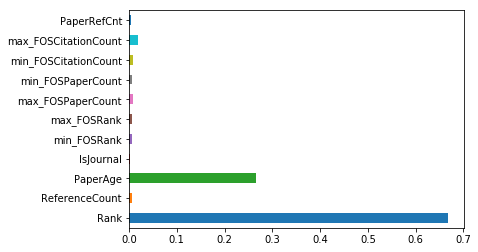

In [44]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [45]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.66728
Feature: 1, Score: 0.00668
Feature: 2, Score: 0.26489
Feature: 3, Score: 0.00227
Feature: 4, Score: 0.00708
Feature: 5, Score: 0.00580
Feature: 6, Score: 0.00930
Feature: 7, Score: 0.00673
Feature: 8, Score: 0.00799
Feature: 9, Score: 0.01858
Feature: 10, Score: 0.00339


## XGBoost Regression model

In [46]:
import xgboost as xgb

In [47]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [48]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 283412,  283413,  283414, ..., 1417056, 1417057, 1417058]), 'TEST:', array([     0,      1,      2, ..., 283409, 283410, 283411]))
('Mean Absolute Error of XGBoost Kfold:', 5.393419800507017)
('Mean Squared Error of XGBoost Kfold:', 19363.92122534158)
('Root Mean Squared Error of XGBoost Kfold:', 139.15430724681713)
('TRAIN:', array([      0,       1,       2, ..., 1417056, 1417057, 1417058]), 'TEST:', array([283412, 283413, 283414, ..., 566821, 566822, 566823]))
('Mean Absolute Error of XGBoost Kfold:', 6.040662606417529)
('Mean Squared Error of XGBoost Kfold:', 4326.705462584247)
('Root Mean Squared Error of XGBoost Kfold:', 65.7776973037537)
('TRAIN:', array([      0,       1,       2, ..., 1417056, 1417057, 1417058]), 'TEST:', array([566824, 566825, 566826, ..., 850233, 850234, 850235]))
('Mean Absolute Error of XGBoost Kfold:', 3.3676714609710126)
('Mean Squared Error of XGBoost Kfold:', 19640.94585352779)
('Root Mean Squared Error of XGBoost Kfold:', 140.146158

In [49]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 86.87902052757825)


In [50]:
importances = regressor.feature_importances_

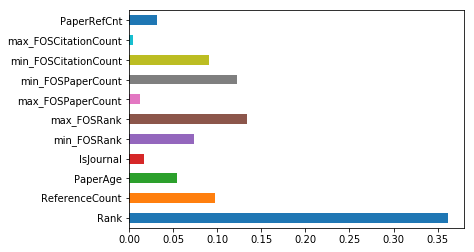

In [51]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [52]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.36151
Feature: 1, Score: 0.09728
Feature: 2, Score: 0.05408
Feature: 3, Score: 0.01744
Feature: 4, Score: 0.07388
Feature: 5, Score: 0.13439
Feature: 6, Score: 0.01234
Feature: 7, Score: 0.12195
Feature: 8, Score: 0.09087
Feature: 9, Score: 0.00483
Feature: 10, Score: 0.03142
